In [321]:
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict,Annotated,Sequence,List
from langchain_core.messages import BaseMessage
from langchain_core.prompts import PromptTemplate
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.agents import AgentExecutor, create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph,END
import operator
from pydantic import BaseModel,Field
import os
from dotenv import load_dotenv



# Load environment variables from .env file
load_dotenv()

True

In [322]:
print("all ok")

all ok


### select model

In [323]:

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
model = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
output = model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


### conf embedding model

In [324]:

embeddings = HuggingFaceEmbeddings(model_name = "BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

In [325]:
loader = DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)

In [326]:
docs = loader.load()

In [327]:
## entire doc is in the doc. we need to do chunking
docs

[Document(metadata={'source': '../data/usa.txt'}, page_content="🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks

In [328]:
docs[0].page_content

"🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the highest, hover

In [329]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 50
)

In [330]:
new_docs = text_splitter.split_documents(documents=docs)

In [331]:
doc_string = [doc.page_content for doc in docs]

In [332]:
db = Chroma.from_documents(new_docs,embeddings)

In [333]:
retriever = db.as_retriever(search_kwargs = {"k":3})


In [334]:
retriever.invoke("industry growth in USA")

[Document(metadata={'source': '../data/usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '../data/usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '../data/usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation')]

create pydantic

In [335]:


class TopicSelectionParser(BaseModel):
    Topic:str = Field(descrition = "Selected Topic")
    Reasoning:str = Field(descrition = "Reasoning behind topic selection")

In [336]:
parse = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [337]:
parse.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"descrition": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"descrition": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"descrition": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"descrition": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [338]:
class AgentState(TypedDict):
    messages :Annotated[Sequence[BaseMessage],operator.add]
    validation_passs: bool
    output:str


In [339]:
def function_1(state:AgentState):
    #supervisor 
    # get the recent message

    question = state['messages'][-1]
    print("Question ",question)
    template = """
        Your task is to classify the given user query into one of the following categories : 
        [AI: If the content in the users question is related to basics of Artificial Intelligence, 
        Basic : If the content in the users question is basic or conversational or doesn't need any real time information and not realted to any specific techniques,
        Online : If the question asked by user needs information that happened recently or realtime other than basic AI and you won't have data related to the question]. 
        Only respond with category name and nothing else

        User Query:{question}
        {format_instructions}
        """
    prompt = PromptTemplate(
        template = template,
        input_variable = ["question"],
        partial_variables={"format_instructions":parse.get_format_instructions()}
    )
    chain = prompt | model | parse
    response = chain.invoke({"question":question})
    print("parsed response",state)
    return {"message":[response.Topic],"validation_passs":False}


In [340]:
state = {"messages":["how are you?"],"validation_error":"","validation_passs":True,"output":""}
function_1(state)

Question  how are you?
parsed response {'messages': ['how are you?'], 'validation_error': '', 'validation_passs': True, 'output': ''}


{'message': ['Basic'], 'validation_passs': False}

In [341]:
def router(state:AgentState):
    print(" -> Router")
    last_message = state["messages"][-1]
    print("last message is ",last_message)
    if "ai" in last_message.lower():
        return "RAG Call"
    elif "basic" in last_message.lower():
        return "LLM Call"
    else:
        return "WEB Call"



In [342]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [343]:
# RAG Function

def function_2(state:AgentState):
    print(" -> RAG Call")
    question = state["messages"][-1]
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following piece of retrieved context to answer the question. If you dont know the 
        answer, just say that you dont know. Use three sentences maximum and keep the answer concise. \nQuestion:{question} \Context {context} \n Answer""",
        input_variables=['context','question']

    )
    rag_chain = (
        {"context":retriever | format_docs,"question":RunnablePassthrough()}
        | prompt
        | model
        |StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return {"output":[result]}



In [344]:
# LLM Function
def function_3(state:AgentState):
    print(" -> LLM Call")
    question = state["messages"][-1]
    complete_query = "Answer the following question with you knowledge of the real world. Following is the user question: "+question
    response = model.invoke(complete_query)
    return {"output":[response.content]}

In [345]:
def function_4(state:AgentState):
    print("-> Online Search")
    os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
    search_tool = TavilySearchResults(max_results=5)
    #search = DuckDuckGoSearchRun()
    tools = [search_tool]
    question = state["messages"][-1]

    template = """
        You are a helpful assistant. You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    User Query:{question}
    Thought:{agent_scratchpad}
        """
    
    prompt = PromptTemplate(
        template = template,
        input_variable = ["question"],
        partial_variables={"format_instructions":parse.get_format_instructions()}
    )
        # Create the agent
    agent = create_react_agent(model, tools, prompt)

    # Create an AgentExecutor to run the agent
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)
    response = agent_executor.invoke({"question": state["messages"][-1], "tool_names": ", ".join([tool.name for tool in tools]), "tools": tools})
    return {"output":[response["output"]]}
    


In [346]:
state = {"messages":["what is today's news in ahamedabad"],"validation_error":"","validation_passsed":0,"output":[]}
function_4(state)

-> Online Search


> Entering new AgentExecutor chain...
Thought:I need to use the Tavily search API to find today's news in Ahmedabad.

Action: tavily_search_results_json
Action Input: "today's news Ahmedabad"
[{'title': 'Air India Plane Crash in Ahmedabad LIVE Updates', 'url': 'https://indianexpress.com/article/india/ahmedabad-plane-crash-live-updates-10062373/', 'content': '**Air India Plane Crash in Ahmedabad Today Live News Updates:**\xa0**[Prime Minister Narendra Modi](https://indianexpress.com/article/cities/ahmedabad/modi-ahmedabad-air-india-flight-crash-boeing-hospital-visit-10064322/)**is in Ahmedabad today to take stock of the situation, a day after the deadly Boeing 787-8 Dreamliner crashed killing 241 onboard. He visited the accident site near the Ahmedabad airport and also met those injured, currently receiving treatment in the city’s Civil Hospital. He [...] # Air India Plane Crash in Ahmedabad LIVE Updates: PM Modi meets former Gujarat CM Vijay Rupani’s wife, family at 

{'output': ["Today's news in Ahmedabad is dominated by a major Air India plane crash that occurred near the Ahmedabad airport.  The crash resulted in numerous casualties, and rescue efforts are underway.  Prime Minister Narendra Modi has visited the crash site and met with injured individuals.  Various news sources are reporting on the incident, including updates on the number of casualties and the ongoing investigation."]}

In [347]:
def validation(state:AgentState):
    print(" -> Validation")
    question = state["messages"][-1]
    answer = state["output"]
    print(question)
    prompt = PromptTemplate(
        template="""You are an expert validator of the output. you will receive the users query{question} and the corresponding {answer} provided by the model. You will evaluate the output and give a final verdict saying answer is valid or not based on the context of response. I would want you to give the output as 
        False : for valid result
        True : being not valid
        ]
        """,
        input_variables=['question','output']

    )
    chain = prompt | model
    response = chain.invoke({"question":question,"answer":answer})
    print(response.content)
    return {"validation_passs":response.content}

In [348]:
state = {"messages":["what is today's weather in ahamedabad"],"validation_error":"","validation_passsed":0,"output":["Today's major news in Ahmedabad is a devastating Air India plane crash that resulted in numerous fatalities.  Multiple news sources are reporting on the incident, including details about the crash, the ongoing investigation, and the response from officials."]}
validation(state)

 -> Validation
what is today's weather in ahamedabad
True


{'validation_passs': 'True'}

In [371]:
def validation_router(state:AgentState):
    print(" -> Validation_Router")
    last_message = state["messages"][-1]
    validation = state["validation_passs"]
    print("validation is ",validation)
    print(validation)
    if validation :
        return "END"
    
    else:
        return "Supervisor"

In [372]:
def final_msg(state:AgentState):
    return {"messages":state["output"]}

In [373]:
state = {"messages":[""],'validation_passs': False}
validation_router(state)

 -> Validation_Router
validation is  False
False


'Supervisor'

In [374]:
workflow = StateGraph(AgentState)

In [375]:
workflow.add_node("Supervisor",function_1)

In [376]:
workflow.add_node("RAG",function_2)

In [377]:
workflow.add_node("LLM",function_3)

In [378]:
workflow.add_node("WEB",function_4)

In [379]:
workflow.add_node("Validation",validation)

In [380]:
workflow.add_node("END",final_msg)

In [381]:
workflow.set_entry_point("Supervisor")

In [382]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call":"RAG",
        "LLM Call" :"LLM",
        "WEB Call" :"WEB"
    }
)

In [383]:
workflow.add_edge("RAG","Validation")
workflow.add_edge("LLM","Validation")
workflow.add_edge("WEB","Validation")

# Conditional routing from validator based on validation_passed
workflow.add_conditional_edges(
    "Validation",
    validation_router,
    {
        "END" : "END",
        "Supervisor" :"Supervisor",
        
    }
)
workflow.add_edge("END",END)


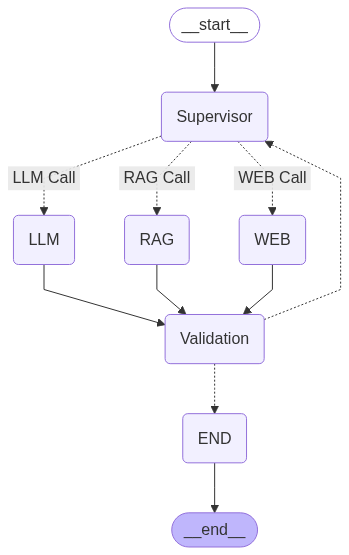

In [384]:
workflow.compile()

In [385]:
app = workflow.compile()

In [386]:
state = {"messages":["what is the population of USA"]}
app.invoke(state)

Question  what is the population of USA
parsed response {'messages': ['what is the population of USA']}
 -> Router
last message is  what is the population of USA
-> Online Search


> Entering new AgentExecutor chain...
Thought:I need to find the population of the USA.  I can use the Tavily search tool to find this information.

Action: tavily_search_results_json
Action Input: "population of USA"
[{'title': 'Demographics of the United States - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Demographics_of_the_United_States', 'content': 'The [United States](/wiki/United_States "United States") is the [third most populous country](/wiki/List_of_countries_and_dependencies_by_population "List of countries and dependencies by population") in the world, and the [most populous in the Americas](/wiki/List_of_countries_in_the_Americas_by_population "List of countries in the Americas by population") and the [Western Hemisphere](/wiki/Western_Hemisphere "Western Hemisphere"), with an estimated 

{'messages': ['what is the population of USA',
  'The estimated population of the USA as of July 1, 2024, is 340,110,988.'],
 'validation_passs': 'False',
 'output': ['The estimated population of the USA as of July 1, 2024, is 340,110,988.']}

In [387]:
state = {"messages":["who invented mathematics"]}
app.invoke(state)

Question  who invented mathematics
parsed response {'messages': ['who invented mathematics']}
 -> Router
last message is  who invented mathematics
-> Online Search


> Entering new AgentExecutor chain...
Thought:I need to find information about the origins of mathematics.  It's unlikely a single person invented it, as it developed over time and across cultures.  I'll use Tavily Search to find information on the history of mathematics.

Action: tavily_search_results_json
Action Input: "history of mathematics"
[{'title': 'History of mathematics - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/History_of_mathematics', 'content': 'The **history of mathematics** deals with the origin of discoveries in [mathematics](https://en.wikipedia.org/wiki/Mathematics "Mathematics") and the [mathematical methods and notation of the past](https://en.wikipedia.org/wiki/History_of_mathematical_notation "History of mathematical notation"). Before the [modern age](https://en.wikipedia.org/wiki/Modern_age

{'messages': ['who invented mathematics',
  "Mathematics wasn't invented by a single person.  It developed gradually over thousands of years across numerous cultures."],
 'validation_passs': 'False',
 'output': ["Mathematics wasn't invented by a single person.  It developed gradually over thousands of years across numerous cultures."]}